In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import load_dataset

In [77]:
# Split the data into train and test sets
split = 0.2
df = pd.read_csv('data/electronics_sample.csv')

df = df[['reviewText', 'overall']].rename(columns={'reviewText': 'text', 'overall': 'label'})
df['label'] = df['label'].astype(float)
df = df.dropna()


df = df[:100000]

df_train, df_test = train_test_split(df, test_size=split, random_state=1)

In [78]:
# Normalize the text
def normalize(df):
    df['text'] = df['text'].str.lower()
    df['text'] = df['text'].str.replace(r'[^a-z0-9\s]', '')
    return df

df_train = normalize(df_train)
df_test = normalize(df_test)

/var/folders/s3/51rzg94s5318dvd1cr9t6cq40000gn/T/ipykernel_83205/1168182555.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(r'[^a-z0-9\s]', '')


In [79]:
import re

# Noise reduction
# Remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

df_train['text'] = df_train['text'].apply(lambda x: remove_html_tags(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_html_tags(x))

# Expand contractions
import contractions

def expand_contractions(text):
    return contractions.fix(text)

df_train['text'] = df_train['text'].apply(lambda x: expand_contractions(x))
df_test['text'] = df_test['text'].apply(lambda x: expand_contractions(x))

# Remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df_train['text'] = df_train['text'].apply(lambda x: remove_stopwords(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christianjensen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
# NLTK Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sid.polarity_scores(text)['compound']

df_train['sentiment'] = df_train['text'].apply(lambda x: get_sentiment(x))
df_test['sentiment'] = df_test['text'].apply(lambda x: get_sentiment(x))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/christianjensen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [81]:
# Number of characters and words in the text
df_train['num_chars'] = df_train['text'].apply(lambda x: len(x))
df_train['num_words'] = df_train['text'].apply(lambda x: len(x.split()))

df_test['num_chars'] = df_test['text'].apply(lambda x: len(x))
df_test['num_words'] = df_test['text'].apply(lambda x: len(x.split()))

In [83]:
# Bag of words with Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_train['text'].apply(lambda x: x.split()))]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

def get_doc2vec(text):
    return model.infer_vector(text.split())

df_train['doc2vec'] = df_train['text'].apply(lambda x: get_doc2vec(x))
df_test['doc2vec'] = df_test['text'].apply(lambda x: get_doc2vec(x))

# Save Doc2Vec model
model.save('models/doc2vec.model')

In [84]:
# TF-IDF with words appearing in at least 10 documents
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(df_train['text'])

def get_tfidf(text):
    return vectorizer.transform([text]).toarray()[0]

df_train['tfidf'] = df_train['text'].apply(lambda x: get_tfidf(x))
df_test['tfidf'] = df_test['text'].apply(lambda x: get_tfidf(x))

# Save TF-IDF model
import pickle

pickle.dump(vectorizer, open('models/tfidf.pickle', 'wb'))

In [85]:
df_train.head()

,text,label,sentiment,num_chars,num_words,doc2vec,tfidf
17957,glamorous,4.0,0.5106,9,1,"[0.022869734, 0.16723807, 0.14389996, -0.02233...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8390,three stars,3.0,0.0000,11,2,"[0.023132347, 0.15524653, 0.04315128, -0.10118...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19500,sent camera back used could new camera,5.0,0.0000,38,7,"[0.19933283, 0.062481225, 0.11008031, -0.10843...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5091,good laptop,4.0,0.4404,11,2,"[0.07510884, 0.05769736, 0.0022005695, -0.0226...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12777,great device use locally,5.0,0.6249,24,4,"[0.15382144, -0.04097546, 0.09185709, -0.21206...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [86]:
# Create the features and labels
X_train = df_train[['sentiment', 'num_chars', 'num_words', 'doc2vec', 'tfidf']].values.tolist()
X_train = [np.concatenate(([x[0]], [x[1]], [x[2]], x[3], x[4])) for x in X_train]

X_test = df_test[['sentiment', 'num_chars', 'num_words', 'doc2vec', 'tfidf']].values.tolist()
X_test = [np.concatenate(([x[0]], [x[1]], [x[2]], x[3], x[4])) for x in X_test]

y_train = df_train['label'].values.tolist()
y_test = df_test['label'].values.tolist()

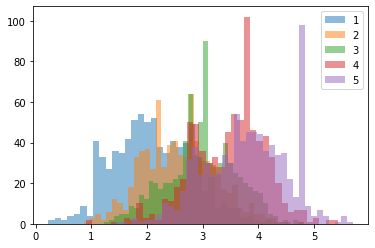

In [87]:
# Plot histogram of predicted values for true values 1-5
import matplotlib.pyplot as plt

for i in range(1, 6):
    plt.hist(y_pred[np.array(y_test) == i], label=str(i), alpha=0.5, bins=40)
plt.legend()
plt.show()

In [88]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [89]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LogisticRegression



models = [
    CatBoostRegressor(iterations=100, loss_function='RMSE', verbose=False),
    XGBRegressor(n_estimators=100, objective='reg:squarederror'),
    LogisticRegression()
]

for model in models:
    print(f'Model: {type(model).__name__} - RMSE:', train_evaluate_model(model, X_train, y_train, X_test, y_test))

KeyboardInterrupt: 

In [90]:
# Train CATBoost model
model = CatBoostRegressor(iterations=100, loss_function='RMSE')
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

# Save model
import pickle

pickle.dump(model, open('model.pkl', 'wb'))

Learning rate set to 0.411876
0:	learn: 1.3060128	total: 75ms	remaining: 7.42s
1:	learn: 1.2450353	total: 125ms	remaining: 6.12s
2:	learn: 1.2122930	total: 170ms	remaining: 5.5s
3:	learn: 1.1949735	total: 221ms	remaining: 5.3s
4:	learn: 1.1857154	total: 271ms	remaining: 5.14s
5:	learn: 1.1736366	total: 316ms	remaining: 4.95s
6:	learn: 1.1672216	total: 360ms	remaining: 4.79s
7:	learn: 1.1603217	total: 406ms	remaining: 4.66s
8:	learn: 1.1529148	total: 457ms	remaining: 4.62s
9:	learn: 1.1481457	total: 498ms	remaining: 4.48s
10:	learn: 1.1430092	total: 538ms	remaining: 4.35s
11:	learn: 1.1382815	total: 580ms	remaining: 4.25s
12:	learn: 1.1338948	total: 622ms	remaining: 4.16s
13:	learn: 1.1304513	total: 668ms	remaining: 4.1s
14:	learn: 1.1269523	total: 719ms	remaining: 4.07s
15:	learn: 1.1226282	total: 770ms	remaining: 4.04s
16:	learn: 1.1191613	total: 813ms	remaining: 3.97s
17:	learn: 1.1165969	total: 860ms	remaining: 3.92s
18:	learn: 1.1138278	total: 913ms	remaining: 3.89s
19:	learn: 1.11

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import contractions
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sid.polarity_scores(text)['compound']

# Normalize the text
def normalize(df):
    df['text'] = df['text'].str.lower()
    df['text'] = df['text'].str.replace(r'[^a-z0-9\s]', '')
    return df

# Noise reduction
# Remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)


# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)


# Remove stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])



# Load Doc2Vec model
doc2vec = Doc2Vec.load('models/doc2vec.model')

def get_doc2vec(text):
    return doc2vec.infer_vector(text.split())


# Load TF-IDF model
tfidf = pickle.load(open('models/tfidf.pickle', 'rb'))

def get_tfidf(text):
    return tfidf.transform([text]).toarray()[0]


# Load model
model = pickle.load(open('model.pkl', 'rb'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christianjensen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/christianjensen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
reviews = ['This is a great product', 'This is a bad product', 'This is a good product', 'This is a terrible product', 'Wow this is amazing'] * 200


df = pd.DataFrame(reviews, columns=['text'])

df = normalize(df)

df['text'] = df['text'].apply(lambda x: remove_html_tags(x))

df['text'] = df['text'].apply(lambda x: expand_contractions(x))

df['text'] = df['text'].apply(lambda x: remove_stopwords(x))

df['num_chars'] = df['text'].apply(lambda x: len(x))
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

df['sentiment'] = df['text'].apply(lambda x: get_sentiment(x))

df['doc2vec'] = df['text'].apply(lambda x: get_doc2vec(x))
df['tfidf'] = df['text'].apply(lambda x: get_tfidf(x))

# Create the features and labels
X = df[['sentiment', 'num_chars', 'num_words', 'doc2vec', 'tfidf']].values.tolist()
X = [np.concatenate(([x[0]], [x[1]], [x[2]], x[3], x[4])) for x in X]

# Predict
y_pred = model.predict(X)

/var/folders/s3/51rzg94s5318dvd1cr9t6cq40000gn/T/ipykernel_86378/3748208050.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(r'[^a-z0-9\s]', '')


In [10]:
y_pred

array([4.15790312, 1.84379287, 3.45454692, 1.57379921, 4.32496566,
       4.15790312, 1.8321106 , 3.45454692, 1.57379921, 4.30368735,
       4.15790312, 1.82251456, 3.45454692, 1.57379921, 4.30368735,
       4.15790312, 1.82251456, 3.45844162, 1.63987402, 4.32496566,
       4.15258971, 1.84379287, 3.47594675, 1.57379921, 4.32496566,
       4.14247075, 1.84379287, 3.44923351, 1.57379921, 4.32496566,
       4.15790312, 1.85338891, 3.45873019, 1.58579791, 4.30368735,
       4.15790312, 1.84379287, 3.44923351, 1.57379921, 4.30339878,
       4.15790312, 1.84379287, 3.4640436 , 1.5684858 , 4.30339878,
       4.15790312, 1.84379287, 3.44923351, 1.58579791, 4.30339878,
       4.15790312, 1.83160116, 3.45454692, 1.57379921, 4.32467709,
       4.15790312, 1.85338891, 3.44894495, 1.57379921, 4.30368735,
       4.15790312, 1.83160116, 3.44923351, 1.58048449, 4.30368735,
       4.15790312, 1.85338891, 3.44894495, 1.57379921, 4.32496566,
       4.15790312, 1.84379287, 3.44894495, 1.58048449, 4.32467